# FILTERING THE DATASET:

Along this script we will get from an initial list of products provided by our client, to a final list (as per the names and ids present within the real data), which will be used to filter our initial data in order to get a smaller, more manageable file.

This process will be divided in two main steps:

- Check the names in our list with the descriptions present in our data, analyze them and select a final list

- Use this list to filter our data and store the resulting information in a more small and convenient file

### CREATING THE LIST OF PRODUCTS FOR THE ANALYSIS:

After rearranging the data in a more convenient manner and doing some introductory analysis of the data, we now want to get down to work with our data.

A list has been given to us of the 10 products that our clients found as more relevant to their business.

What we want now is to check whether the names on the list correspond to certain uniques ids, or, as seen in the previous scripts, some conflict of unicity will arise between the id of our products and their descriptions.

So, we are going to check our dataframe and select from it the ids and descriptions of our products that match the indications given in our clients list. With the lists (in reality, two dictionaries) of the ids and descriptions that match every product given to us, we will decide which are the more appropriate.

Perhaps some guidance from our client would be needed at this stage.

### 0. Index

<a href='#a1'>1. Read dataframe</a>

<a href='#a2'>2. Normalizing and aggregating description names</a>

<a href='#a21'>2.1. Normalizing description names</a>

<a href='#a22'>2.2. Identifying product descriptions that the client wants us to predict</a>

<a href='#a23'>2.3 Review Product by Product</a>

<a href='#a24'>2.4 Concatenate results, merge them back to the  full list of normalized descriptions and evaluate its effectiveness</a>

<a href='#a25'>2.5 Test that data has not been corrputed</a>

<a href='#a26'>2.6 Filter dataset to only include the products from the list provided by the client, and save to csv</a>

<a href='#a27'>2.7 Error checking</a>

### 1. Read dataframe<a id='a1'></a>

In [1]:
# Importing packages:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import math
import seaborn as sns
import os



%matplotlib inline
pd.options.display.max_columns = None

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Defining the search path of the file, the name and the separator:

file_path = "../data/01_raw/"
file_name = "1_b2-transactions.csv" #'b2-transactions_sample.csv' 
exit_path = "../data/02_intermediate/"

filtered_file_name="1-filtered_transactions.csv"

sep=";"

# Create output folder
try:
    os.mkdir(exit_path)
except OSError:
    print ("Path %s already exists" % exit_path)

In [3]:
# We create the list of products provided by the client
list_of_products=['croissant',
                  'croissant petit',
                  'tarta mousse 3 chocolates',
                  'tarta de manzana 2º',
                  'palmera de chocolate'
                  'tarta opera',
                  'postre fresas y mascarpone',
                  'milhojas frambuesa 2º',
                  'tortel',
                  'baguette']

In [4]:
# We import the dataframe:
df=pd.read_csv(file_path+file_name, sep=sep)

In [5]:
df.sample(5)

,product_id,description,order_date,section,store,units_ordered
16680153,231.0,PINCHOS SALCHICHA,2013-03-24,0,GoUP,"0,00"
13686036,113.0,SUIZOS,2009-09-18,0,LiUP,"0,00"
11542231,633.0,PANELLES CAFE,2012-10-10,0,AeUP,"0,00"
8477774,846.0,POSTRE MILHOJAS,2014-05-16,0,JPUP,"4,00"
2864709,317.0,TARRINA PATE ROYAL PORCION,2014-07-14,0,VeUp,"0,00"


### 2. Normalizing and aggregating description names<a id='a2'></a>

Unfortunately, there is no convention for the description and one id could 

1. Normalize descriptions as much as possible using:
    - Regex expressions 
    - Basic NLP for spell-checking.
2. Create a normalization file with the following structure:
    - Unique Product_id and normalized description
    - Flag to indicate if the product is part of the given list, or not.  
3. Finally review the list manually. 

### 2.1. Normalizing description names<a id='a21'></a>

In [6]:
# Setting Null descriptions to 'no-description'
df['description'].fillna('no-description', inplace = True)

# Unique product descriptions
df_descriptions_unique = pd.Series(df['description'].unique())

# Most of the descriptions are in uppercase, however others are in lower:
df_descriptions_normalized = df_descriptions_unique.str.lower()

#replace non alfanumeric with space
df_descriptions_normalized=df_descriptions_normalized.str.replace(r'[^0-9a-zA-Zº()ª:-]+', ' ') 

# We also notice that there are spacing issues at the begining, end of the description and between words:
df_descriptions_normalized=df_descriptions_normalized.str.strip()

# Remove multi-spacing. multi '-' and multi ':'
df_descriptions_normalized=df_descriptions_normalized.str.replace(r' +', ' ') 
df_descriptions_normalized=df_descriptions_normalized.str.replace(r'-+', ' ') 
df_descriptions_normalized=df_descriptions_normalized.str.replace(r':+', ' ') 

In [7]:
pd.DataFrame(dict(desc_original = df_descriptions_unique, desc_normalized = df_descriptions_normalized)).sample(10)

,desc_original,desc_normalized
40967,POTRES MILHOJA FRAMBUESA,potres milhoja frambuesa
8288,"SELVA NEGRA 5º --CON CARTEL "" HAPPY BIRTHDAY...",selva negra 5º con cartel happy birthday prakash
33971,"ENSAIMADA RELLENA 6 RC, RELLENA DE NATA",ensaimada rellena 6 rc rellena de nata
15857,"TIRA DE HOJALDRE Y FRUTA CUADRADA,50 RACIONES....",tira de hojaldre y fruta cuadrada 50 raciones ...
4025,SABLE CON FORMA DE CORAZON,sable con forma de corazon
47993,salsa miso,salsa miso
25853,"CHOCOLATE 3º CON CARTEL ,,FELICIDADES,,",chocolate 3º con cartel felicidades
19058,MOLDE DE PAN MALTA GR.,molde de pan malta gr
14571,EncargoTARTA MILHOJAS DE FRAMBUESA DEL 1.,encargotarta milhojas de frambuesa del 1
40842,Sandwiches Surtidos ( 48 de encargo),sandwiches surtidos ( 48 de encargo)


Now lets gets get our hands dirty and apply some maths to calculate string distnace and finish cleaning all those messy product descriptions... This is what we are going to do:

1. Create a dataset with pastry products by parsing the bakery catalogues, and other pastry websites. (this was done manually, by converting the pdf catalogues to txt using an external web. THe resulting file is named productos.txt)

2. Following the indications from: https://medium.com/@hdezfloresmiguelangel/implementando-un-corrector-ortogr%C3%A1fico-en-python-utilizando-la-distancia-de-levenshtein-498ec0dd1105 create an spell-checker based on the products.txt dataset and the Levenshtein distance


In [8]:
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('../data/_auxiliary_data/productos.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [9]:
correction("trta")

'tarta'

In [10]:
correction("café")

'cafe'

It seems to work. Lets now apply it to our dataset:

In [11]:
def spell_check (line):
    "Given a sentence, returns spell-checks word by word"
    if type(line) == str and len(line) > 0:
        new = []
        line = line.split(" ")
        for word in line:
            if type(word) == str:
                word = correction(word)
            new.append(word)
        return " ".join(new)
            
    else:
        return line

In [12]:
# CAUTION! 

# The following step normalizes all the unique descriptiosn word by word 
# against the words found in the catalogue of the bakery. It requires a lot of hours and, 
# for this reason we have created a shorcut that consist in reading the pre-saved output of the normalization.
# If you want to fully re-create our results, set shorcut to False and grab a cup of coffee (or two) :)

shorcut = True 

if shorcut == True:
    df_descriptions_normalized = pd.read_csv("../data/_auxiliary_data/descriptions_normalized_shortcut.csv")["0"]
else:
    df_descriptions_normalized = df_descriptions_normalized.apply(lambda line: spell_check(line))


Lets now merge the normalized names back to the original file, and check how effective was this cleaning:

In [13]:
to_merge = pd.DataFrame(dict(description = df_descriptions_unique, desc_normalized = df_descriptions_normalized))

df_with_normalized_descriptions_transactions = pd.merge(df, to_merge, how='left', on = 'description').sort_values(by='order_date')
df_with_normalized_descriptions_transactions.sample(5)

,product_id,description,order_date,section,store,units_ordered,desc_normalized
23183628,3336.0,JARRETE DE TERNERA AL VINO BLANCO,2010-03-16,0,PoUP,"0,00",jarrete de ternera al fino blanco
15744624,230.0,PINCHOS DATIL,2015-04-07,0,EnUP,"0,00",pincho datil
24148950,6008.0,NAPOLITANAS CREMA /PIEZA/5HORA,2012-07-17,0,MsUP,"0,00",napolitanas crema riera hora
26590369,5007.0,MINI PITAS unidades,2009-05-19,0,ViUP,"0,00",mini pasas unidades
24688790,3382.0,BRANDADA DE BACALAO PARA RELLENAR VOL AU VENT,2010-02-20,0,MsUP,"0,00",brandada de bacalao para rellena con au venta


In [14]:
#Control merge size:
if (df.shape[0] == df_with_normalized_descriptions_transactions.shape[0] ): 
    test0 = "OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' "
else:
    test0 = "ERROR - 'df' has NOT the same size as 'df_with_normalized_descriptions_transactions' "
print(test0)

OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' 


In [15]:
# Checking effectiveness of the data cleaning:
unique_descriptions_raw = len(df['description'].unique())
unique_descriptions_normalized = len(df_with_normalized_descriptions_transactions['desc_normalized'].unique())

print('The product descritions were cleaned from {} unique names to {}.'.format(unique_descriptions_raw,unique_descriptions_normalized))

The product descritions were cleaned from 48517 unique names to 40026.


Not very effective.

In [16]:
# Saving the file to the intermiady folder
output_path_df_with_normalized_descriptions_transactions = exit_path + '0_data_with_normalized_names.csv'
df_with_normalized_descriptions_transactions.to_csv(output_path_df_with_normalized_descriptions_transactions, index = False, sep = sep)

In [17]:
df_with_normalized_descriptions_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30550252 entries, 18577798 to 21058530
Data columns (total 7 columns):
product_id         float64
description        object
order_date         object
section            int64
store              object
units_ordered      object
desc_normalized    object
dtypes: float64(1), int64(1), object(5)
memory usage: 1.8+ GB


### 2.2. Identifying product descriptions that the client wants us to predict<a id='a22'></a>

It is time to create the file that will be manually reviewed.

- First, we compare the normalized descriptions with the list of products provided with the client, and suggest matches using the library fuzzywuzzy
- Second, we will use the results from the other analysis.
- third, we will manually evaluate if the results are good

#### 2.2.1. Using the library fuzzywuzzy to compare the product normalized descriptions with the list of products provided by the client and suggest a match, or alternatively - "match-not-found"<a id='a221'></a>

In [18]:
output_path_df_with_normalized_descriptions_transactions = exit_path + '0_data_with_normalized_names.csv'
df_with_normalized_descriptions_transactions=pd.read_csv(output_path_df_with_normalized_descriptions_transactions,  sep=sep)

In [19]:
df_with_normalized_descriptions_transactions

,product_id,description,order_date,section,store,units_ordered,desc_normalized
0,201.0,EMPANADA GALLEGA SALMON,2008-01-01,0,GrUP,"2,00",empanadas gallega salmon
1,611.0,CABELLO,2008-01-01,0,AeUP,"0,00",cabello
2,610.0,MANZANA,2008-01-01,0,AeUP,"0,00",manzana
3,609.0,COCO,2008-01-01,0,AeUP,"0,00",choco
4,608.0,CANUTILLOS,2008-01-01,0,AeUP,"0,00",canutillo
5,607.0,PASTEL MILHOJAS,2008-01-01,0,AeUP,"0,00",cartel milhojas
6,606.0,RUSOS,2008-01-01,0,AeUP,"0,00",ruso
7,605.0,DUQUESA DE AVELLANA,2008-01-01,0,AeUP,"0,00",duquesa de avellana
8,574.0,CAJA DE FINANCIEROS,2008-01-01,0,AeUP,"0,00",caja de financieros
9,573.0,CAJA ACETATO DE PASTAS,2008-01-01,0,AeUP,"0,00",caja acetato de pastas


In [20]:
df_normalized_desc_unique = pd.DataFrame(df_with_normalized_descriptions_transactions["desc_normalized"].unique(), columns = ['desc_normalized'])

In [21]:
def find_match (line, options = list_of_products):
    "Returns product match if the the calculated difference between strings is greater than 80, 'match-not-found' otherwise"
    if not(line is None) and type(line)== str:
        highest = process.extractOne(line,list_of_products)
        if not(highest is None) and highest[1] >80:
            return highest[0]
        else:
            return 'match-not-found'
    else:
        return 'match-not-found'

# Applying matching function to all product normalized descriptions
df_normalized_desc_unique["target_names_fuzzywuuzy"] = df_normalized_desc_unique["desc_normalized"].apply(lambda line: find_match(line))

Lets now evaluate how effectively did we match the normalized descriptions with the list that the client provided us:

In [22]:
# Lets review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_normalized_desc_unique[df_normalized_desc_unique['desc_normalized'].str.contains('mousse')].head(10)

,desc_normalized,target_names_fuzzywuuzy
25,mousse chocolate blanco,match-not-found
334,mousse 3 chocolates 3,tarta mousse 3 chocolates
335,mousse 3 chocolates 1,tarta mousse 3 chocolates
336,mousse 3 chocolates 2,tarta mousse 3 chocolates
337,postres mousse tres chocolates,match-not-found
419,postres mousse frutas bosque,match-not-found
421,postres mousse chocolate en vasito,match-not-found
466,postres mousse de limon,match-not-found
473,petit yogur mousse praline,croissant petit
727,postres mousse de tres chocolates,tarta de manzana 2º


As we can see... its not actually very good, lets try something different.

#### 2.2.2 Using the results from the other analysis<a id='a222'></a>

Lets now use the results from the manual analysis to see how efective the measure was:

In [23]:
# Since this matching is performed at id level, 
# lets create a new dataset with unique product_id, descriptions, and evaluate it:
df_normalized_id_desc_unique = df_with_normalized_descriptions_transactions[["product_id",'desc_normalized']].drop_duplicates()

In [24]:
dict_of_products_matches={100: 'croissant', 
                  101: 'croissant',
                  102: 'croissant',
                  103: 'croissant petit',
                  9999: 'tarta mousse 3 chocolates', # almost only for order, creating a new id for this product is suggested
                  462: 'tarta de manzana 2º',
                  182: 'palmera de chocolate', # palmeras: 140
                  414: 'tarta opera', # 9999, for order, mostly. If included, creating a new id for this product is suggested
                  4511:'postre fresas y mascarpone',
                  459: 'milhojas frambuesa 2º',
                  112: 'tortel',
                  115: 'baguette'}

In [25]:
def target_names_a(product_id, dict_of_products_matches= dict_of_products_matches):
    'Returns match if the product_id is found within the given dict or, otherise "match-not-found"'
    if not(product_id is None) and not(math.isnan(product_id)) and int(product_id)  in dict_of_products_matches:
        return dict_of_products_matches[int(product_id)]
    else:
        return 'match-not-found'
    
df_normalized_id_desc_unique['target_names_manual_analysis']=df_normalized_id_desc_unique["product_id"].apply(lambda line: target_names_a(line))

Lets now check how effective this was:

In [26]:
# Lets review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_normalized_id_desc_unique[df_normalized_id_desc_unique['desc_normalized'].str.contains('mousse')].head(15)

,product_id,desc_normalized,target_names_manual_analysis
25,618.0,mousse chocolate blanco,match-not-found
452,453.0,mousse 3 chocolates 3,match-not-found
453,452.0,mousse 3 chocolates 1,match-not-found
454,451.0,mousse 3 chocolates 2,match-not-found
455,450.0,postres mousse tres chocolates,match-not-found
823,879.0,postres mousse frutas bosque,match-not-found
825,877.0,postres mousse chocolate en vasito,match-not-found
871,821.0,postres mousse de limon,match-not-found
878,728.0,petit yogur mousse praline,match-not-found
23848,9999.0,postres mousse de tres chocolates,tarta mousse 3 chocolates


Again, not very good, since most of the 'mousse 3 chocolates' are unmatched.

It is clear that we need an better way to match the results. Lets try doing keywords filtering product by product.

## 2.3 Review Product by Product<a id='a23'></a>

In [27]:
# AUXILIARY CODE (this cell is used to avoid executing the previous part of the code that takes very long hours)
output_path_df_with_normalized_descriptions_transactions = exit_path + '0_data_with_normalized_names.csv'
df_with_normalized_descriptions_transactions = pd.read_csv(output_path_df_with_normalized_descriptions_transactions, sep = ';' )


In [28]:
#First, lets create again a dataframe with unique descriptions
unique_normalized_decriptions = df_with_normalized_descriptions_transactions[['product_id','desc_normalized']].drop_duplicates()

#And a empty list to add all the unitary analysis. It will be use to concatenate results.
list_of_dfs = []

In [29]:
# Functions that we will use:

def plot_count_per_id(df):
    transactions_by_id = df.groupby("product_id")['desc_normalized'].count()
    transactions_by_id.plot.bar()

#### 2.3.1 Matching: milhojas de frambuesa 2º

In [30]:
def filter_milhojas (df):
    'Filters the product descriptions of given dataset by "milhojas" and "frambuesa 2"'
    milhojas = df[df['desc_normalized'].str.contains('milhojas')]
    milhojas_frambuesa = milhojas[milhojas['desc_normalized'].str.contains('frambuesa 2')].copy()
    return milhojas_frambuesa


In [31]:
# Filter the transactions dataset
milhojas_frambuesa_transacciones=filter_milhojas(df_with_normalized_descriptions_transactions)
milhojas_frambuesa_transacciones.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
97,414.0,TARTA MILHOJAS FRAMBUESA 2º,2008-01-01,0,AeUP,"0,00",tarta milhojas frambuesa 2
449,459.0,MILHOJAS FRAMBUESA 2º,2008-01-01,0,AeUP,"0,00",milhojas frambuesa 2
761,414.0,TARTA MILHOJAS FRAMBUESA 2º,2008-01-01,0,MsUP,"0,00",tarta milhojas frambuesa 2
769,459.0,MILHOJAS FRAMBUESA 2º,2008-01-01,0,BmUP,"1,00",milhojas frambuesa 2
1142,414.0,TARTA MILHOJAS FRAMBUESA 2º,2008-01-01,0,JPUP,"0,00",tarta milhojas frambuesa 2


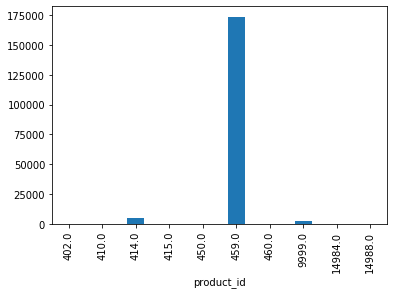

In [32]:
# Plot the ditribution of 'product_id'
plot_count_per_id(milhojas_frambuesa_transacciones)

Lets explore the names distribution of 414, 459 and 9999:

In [33]:
#Names distribution for product_id = 459:
df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==459.0]['desc_normalized'].value_counts().head()

milhojas frambuesa 2                       167542
milhojas frambuesa 1                         1311
tiras de milhojas rellena solo de crema       532
milhojas frambuesa 3                          437
milhojas frambuesa 2 solo crema               399
Name: desc_normalized, dtype: int64

In [34]:
#Names distribution for product_id = 414:
df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==414.0]['desc_normalized'].value_counts().head()

tarta mus tres chocolates 2    4807
tarta milhojas frambuesa 2     4123
tarta limon 3                  3420
tarta milhojas 2               1824
tarta tres chocolates 2        1805
Name: desc_normalized, dtype: int64

In [35]:
#Names distribution for product_id = 9999:
df_with_normalized_descriptions_transactions[(df_with_normalized_descriptions_transactions['product_id']==9999.0) & (df_with_normalized_descriptions_transactions['desc_normalized'].str.contains('milhoja'))]['desc_normalized'].value_counts().head()

tarta milhojas frambuesa 2                  950
encargo tarta milhojas del 1                912
tiras de milhojas solo crema                912
tarta milhojas de frambuesa del 3           855
encargo tarta milhojas y frambuesa del 1    798
Name: desc_normalized, dtype: int64

It seems there is a strong correlation with id 459, however 459 it also includes other types of 'milhojas'. In addition, 'milhojas de frambuesa 2º' is also included in id number 414, which seems to be a multiple 'tartas' id, and id 9999, which is the id used for custom orders.

For these reasons, we decide to filter milhojas based on the description (filtering the dataframe with only disting 'product_id' and 'des_normalized' values:

In [36]:
#Save unique product_id and product_description:
milhojas_frambuesa = filter_milhojas(unique_normalized_decriptions)
milhojas_frambuesa['target_names_prod_by_prod'] = 'milhojas frambuesa'
list_of_dfs.append(milhojas_frambuesa)
milhojas_frambuesa.sample(5)

,product_id,desc_normalized,target_names_prod_by_prod
28460768,9999.0,tarta milhojas de frambuesa 20 raciones cortad...,milhojas frambuesa
18771247,459.0,milhojas frambuesa 2 con cartel que olga felic...,milhojas frambuesa
16635057,459.0,milhojas frambuesa 2 con cartel y felicidades ...,milhojas frambuesa
1033764,459.0,milhojas frambuesa 2 con cartel felicidades al...,milhojas frambuesa
29631281,459.0,milhojas frambuesa 2 con cartel felicidades ra...,milhojas frambuesa


#### 2.3.2 Matching: croissant petite

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'croissant petite' had an strong correlation with id number '103' however, before commiting to filtering by that ID, lets plot the distribution of count of lines per ID, that satisfies the filters of the following function, from the transaction dataset, in order to :

In [37]:
def filter_croissant_petit (df):
    croissant = df[df['desc_normalized'].str.contains('croissant')].copy()
    croissant_petite = croissant[croissant['desc_normalized'].str.contains('petit')].copy()
    return croissant_petite

In [38]:
# Plotting the results:
transactions_croissant_petite = filter_croissant_petit(df_with_normalized_descriptions_transactions)
transactions_croissant_petite.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
95,102.0,PETIT CROISSANTS ALARGADOS FUTBOL,2008-01-01,0,AeUP,"0,00",petit croissant alargados futbol
200,103.0,CROISSANT PETIT,2008-01-01,0,BmUP,"6,00",croissant petit
274,102.0,PETIT CROISSANTS ALARGADOS FUTBOL,2008-01-01,0,BmUP,"0,00",petit croissant alargados futbol
517,103.0,CROISSANT PETIT,2008-01-01,0,MsUP,"0,00",croissant petit
689,103.0,CROISSANT PETIT,2008-01-01,0,AeUP,"0,00",croissant petit


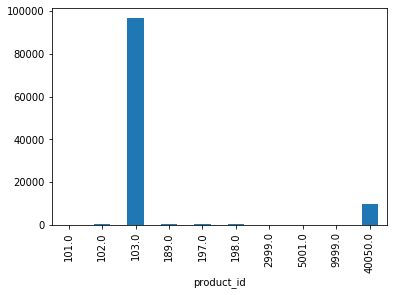

In [39]:
plot_count_per_id(transactions_croissant_petite)

It is clear that id '103' represents the 'croissant petite';  in fact, after reviweing the data with the client, he suggested only taking 103.

In [40]:
# Saving id=103 as croissant petit
croissant_petit = unique_normalized_decriptions[unique_normalized_decriptions['product_id']==103.0].copy()
croissant_petit['target_names_prod_by_prod'] = 'croissant petit'
list_of_dfs.append(croissant_petit)
croissant_petit.head()

,product_id,desc_normalized,target_names_prod_by_prod
73,103.0,mini napolitanas crema,croissant petit
74,103.0,mini napolitanas chocolate,croissant petit
75,103.0,focaccias futbol,croissant petit
200,103.0,croissant petit,croissant petit
61311,103.0,palmeritas de chocolate piezas 40,croissant petit


#### 2.3.3 Matching: croissant

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'croissant simple' had an strong correlation with id number '100' and '101' however, before commiting to filtering by that ID, lets plot the distribution of count of lines per ID, that satisfies the filters of the following function, from the transaction dataset, in order to :

In [41]:
def filter_croissant_simple (df):
    croissant = df[df['desc_normalized'].str.contains('croissant')].copy()
    croissant_simple = croissant[~croissant['desc_normalized'].str.contains('petit|tira|masa')].copy()
    return croissant_simple

In [42]:
transactions_croissant_simple = filter_croissant_simple(df_with_normalized_descriptions_transactions)
transactions_croissant_simple.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
34,215.0,CROISANNT SOBRASADA PQ COCIDOS,2008-01-01,0,BmUP,"1,00",croissant sobrasada px cocido
130,215.0,CROISANNT SOBRASADA PQ COCIDOS,2008-01-01,0,AeUP,"0,00",croissant sobrasada px cocido
179,101.0,CROISSANT,2008-01-01,0,BmUP,"6,00",croissant
190,100.0,CROISANTS,2008-01-01,0,BmUP,"0,00",croissant
197,107.0,CROISSANT VACIOS,2008-01-01,0,BmUP,"4,00",croissant racion


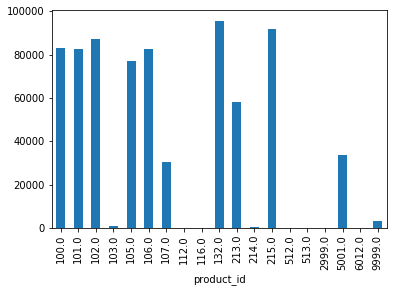

In [43]:
plot_count_per_id(transactions_croissant_simple)

Interesting, the correlation seems to exsit for several ids... Lets explore a bit more... Lets plot the most common description from each id and see if we find any pattern:

In [44]:
for i in transactions_croissant_simple['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 215.0 
-
croissant sobrasada px cocido                         91580
croissant sobrasada px cocido de encargo                 76
croissant sobrasada px cocido encargo                    38
croissant sobrasada px cocido en el duro n del pan       19
mini hamburguesitas                                      19
Name: desc_normalized, dtype: int64

***Plotting id: 101.0 
-
croissant                        72124
croissant andes marcos piezas     8550
suizos piezas hacer 10            4180
ensaimadas piezas hacer 10        3477
tiras de focaccias                2432
Name: desc_normalized, dtype: int64

***Plotting id: 100.0 
-
croissant                       80598
croissant normal mango           1197
croissant alargados piezas        342
croissant piezas alargadas        133
croissant alargados y piezas       95
Name: desc_normalized, dtype: int64

***Plotting id: 107.0 
-
croissant racion            29716
croissant almendra mango      532
Name: desc_normalized, dtype: int64


It seems that they have different types of croissant. Checking with the client, he suggested taking only: 100.0 and 101.0 that contains the word 'croissant'

In [45]:
croissant_simple = unique_normalized_decriptions[(unique_normalized_decriptions['product_id']==100.0)|(unique_normalized_decriptions['product_id']==101.0)].copy()
croissant_simple = croissant_simple[croissant_simple['desc_normalized'].str.contains('croissant')]
croissant_simple = croissant_simple[~croissant_simple['desc_normalized'].str.contains('petit|tira|masa')].copy()

croissant_simple['target_names_prod_by_prod'] = 'croissant simple'
list_of_dfs.append(croissant_simple)
croissant_simple.head()

,product_id,desc_normalized,target_names_prod_by_prod
179,101.0,croissant,croissant simple
190,100.0,croissant,croissant simple
145410,101.0,croissant andes alargados piezas,croissant simple
1015835,101.0,croissant alargados andes piezas,croissant simple
1263320,101.0,croissant andes marcos piezas,croissant simple


#### 2.3.4 Matching: tarta mousse tres chocolates

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'mousse tres chocolates' had no correlation with a particular product_id, therefore the analysis will be based on the description:

In [46]:
def filter_mousse_tres_chocolates (df):
    tarta = df[df['desc_normalized'].str.contains('tarta')].copy()
    mousse = tarta[tarta['desc_normalized'].str.contains('mousse|mus')].copy()
    mousse_tres = mousse[mousse['desc_normalized'].str.contains('tres|3')].copy()
    mousse_tres = mousse_tres[~mousse_tres['desc_normalized'].str.contains('mini')].copy()
    mousse_tres_chocolates = mousse_tres[mousse_tres['desc_normalized'].str.contains('chocolate')].copy()
    return mousse_tres_chocolates

In [47]:
transactions_mousse_tres_chocolates = filter_mousse_tres_chocolates(df_with_normalized_descriptions_transactions)
transactions_mousse_tres_chocolates.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
98,414.0,TARTA MUS TRES CHOCOLATES 2º,2008-01-01,0,AeUP,"0,00",tarta mus tres chocolates 2
762,414.0,TARTA MUS TRES CHOCOLATES 2º,2008-01-01,0,MsUP,"0,00",tarta mus tres chocolates 2
1141,414.0,TARTA MUS TRES CHOCOLATES 2º,2008-01-01,0,JPUP,"0,00",tarta mus tres chocolates 2
1312,414.0,TARTA MUS TRES CHOCOLATES 2º,2008-01-01,0,GrUP,"0,00",tarta mus tres chocolates 2
1363,414.0,TARTA MUS TRES CHOCOLATES 2º,2008-01-01,0,BmUP,"0,00",tarta mus tres chocolates 2


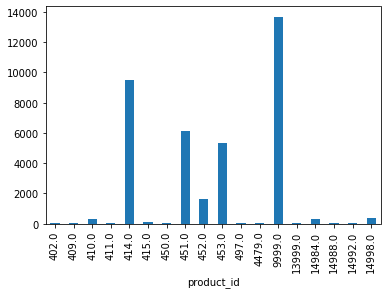

In [48]:
plot_count_per_id(transactions_mousse_tres_chocolates)

Interesting... Lets explore it more by having a look at the full distribution of names:

In [49]:
for i in transactions_mousse_tres_chocolates['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 414.0 
-
tarta mus tres chocolates 2    4807
tarta milhojas frambuesa 2     4123
tarta limon 3                  3420
tarta milhojas 2               1824
tarta tres chocolates 2        1805
Name: desc_normalized, dtype: int64

***Plotting id: 14992.0 
-
tarta mousse tres chocolates 6 escrito felix cumplea on    19
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5073
Name: desc_normalized, dtype: int64

***Plotting id: 450.0 
-
postres mousse tres chocolates      82403
postres selva negra                  3116
postres milhojas frambuesa           2926
mini postres mus tres chocolates     2014
postres milhojas                     1976
Name: desc_normalized, dtype: int64

***Plotting id: 14998.0 
-
tartas especiales                                                                     38
t

It seems that 'tarta mousse tres chocolates' is all over the place... So the easiest is to filter by product description"

In [50]:
mousse_tres_chocolates = filter_mousse_tres_chocolates(unique_normalized_decriptions)
mousse_tres_chocolates['target_names_prod_by_prod'] = 'mousse tres chocolates'
list_of_dfs.append(mousse_tres_chocolates)
mousse_tres_chocolates.head()

,product_id,desc_normalized,target_names_prod_by_prod
98,414.0,tarta mus tres chocolates 2,mousse tres chocolates
95419,14992.0,tarta mousse tres chocolates 6 escrito felix c...,mousse tres chocolates
116962,414.0,tarta mus tres chocolate 2,mousse tres chocolates
116963,414.0,tarta mus tres chocolates 1,mousse tres chocolates
163605,9999.0,tarta mousse de 3 chocolates del 4 primer coche,mousse tres chocolates


#### 2.3.5 Matching: tarta de manzana 2
From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'tarta de manzana 2' had no correlation with a particular product_id, therefore the analysis will be based on the description:

In [51]:
def filter_tarta_manzana_2 (df):
    manzana_tarta = df[df['desc_normalized'].str.contains('manzana')]
    #manzana_tarta = manzana[manzana['desc_normalized'].str.contains('tarta')].copy() #Removed because we saw it had better fit
    manzana_tarta = manzana_tarta[~manzana_tarta['desc_normalized'].str.contains('caramelo')].copy()
    manzana_tarta_dos = manzana_tarta[manzana_tarta['desc_normalized'].str.contains('dos|2')].copy()

    return manzana_tarta_dos

In [52]:
transactions_manzana_tarta_dos=filter_tarta_manzana_2(df_with_normalized_descriptions_transactions)

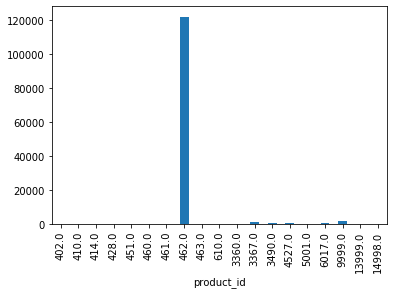

In [53]:
plot_count_per_id(transactions_manzana_tarta_dos)

Looks like we found a winner!

In [54]:
manzana_tarta_dos = filter_tarta_manzana_2(unique_normalized_decriptions)
manzana_tarta_dos['target_names_prod_by_prod'] = 'tarta de manzana'
list_of_dfs.append(manzana_tarta_dos)
manzana_tarta_dos.head()

,product_id,desc_normalized,target_names_prod_by_prod
52206,6017.0,tarta manzana y a 2 y hora 5,tarta de manzana
52518,462.0,manzana 2,tarta de manzana
95868,3490.0,c microcanal 1 2 g verde manzana,tarta de manzana
173050,9999.0,encargo tarta de manzana 2 cartel que olga fel...,tarta de manzana
235282,9999.0,tarta manzana de verde al del 2,tarta de manzana


#### 2.3.6 Matching: palmera de chocolate 

In [55]:
def filter_palmera_chocolate (df):
    palmera = df[df['desc_normalized'].str.contains('palmera')]
    palmera_chocolate = palmera[palmera['desc_normalized'].str.contains('chocolate|trufa')].copy() #Added trufa after reviwing results
    return palmera_chocolate

In [56]:
transactions_palmera_chocolate = filter_palmera_chocolate(df_with_normalized_descriptions_transactions)
transactions_palmera_chocolate.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
145,182.0,PALMERAS DE TRUFA,2008-01-01,0,AeUP,"0,00",palmera de trufa
348,182.0,PALMERAS DE TRUFA,2008-01-01,0,BmUP,"3,00",palmera de trufa
612,182.0,PALMERAS DE TRUFA,2008-01-01,0,MsUP,"0,00",palmera de trufa
2048,182.0,PALMERAS DE TRUFA,2008-01-01,0,AnUP,"3,00",palmera de trufa
2961,182.0,PALMERAS DE TRUFA,2008-01-01,0,GrUP,"4,00",palmera de trufa


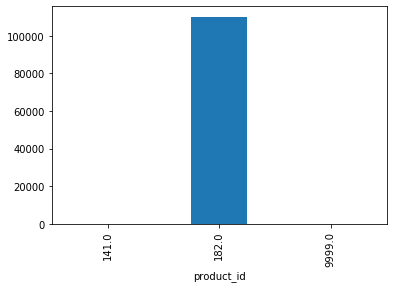

In [57]:
plot_count_per_id(transactions_palmera_chocolate)

Again, we have a winner!

In [58]:
palmera_chocolate = filter_palmera_chocolate(unique_normalized_decriptions)
palmera_chocolate['target_names_prod_by_prod'] = 'palmera chocolate'

list_of_dfs.append(palmera_chocolate)
palmera_chocolate.head()

,product_id,desc_normalized,target_names_prod_by_prod
145,182.0,palmera de trufa,palmera chocolate
3033562,141.0,palmera chocolate,palmera chocolate
3862812,182.0,palmera de trufa y y encargo y y,palmera chocolate
9003746,182.0,palmera de trufa hoy 50 de encargo,palmera chocolate
15525027,9999.0,palmera de chocolate unidades,palmera chocolate


#### 2.3.7 Matching: tarta ópera 

In [59]:
def filter_tarta_opera(df):
    opera = df[df['desc_normalized'].str.contains('opera')]
    opera_tarta = opera[opera['desc_normalized'].str.contains('tarta')].copy()
    return opera_tarta

In [60]:
transactions_tarta_opera = filter_tarta_opera(df_with_normalized_descriptions_transactions)

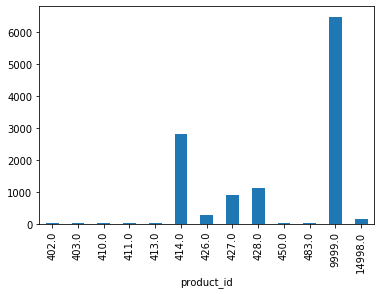

In [61]:
plot_count_per_id(transactions_tarta_opera)

In [62]:
for i in transactions_tarta_opera['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5073
Name: desc_normalized, dtype: int64

***Plotting id: 14998.0 
-
tartas especiales                                                                     38
tarta mousse de tres chocolates del 4                                                 38
tarta saint honore del 4                                                              38
tartas especiales de 10 de mickey de 12 la con el bizcocho de selva negra             38
tartas especial manzana del 3 con c cartel que olga felix cumplea on david encargo    19
Name: desc_normalized, dtype: int64

***Plotting id: 414.0 
-
tarta mus tres chocolates 2    4807
tarta milhojas frambuesa 2     4123
tarta limon 3                  3420
tarta milhojas 2               1824
tarta tres chocolates 2        1805
Name: desc_normalized, dtype: int64

***Plo

Again, all over the place, so we decided to use the description filter:

In [63]:
tarta_opera = filter_tarta_opera(unique_normalized_decriptions)
tarta_opera['target_names_prod_by_prod'] = 'tarta opera'

list_of_dfs.append(tarta_opera)
tarta_opera.head()

,product_id,desc_normalized,target_names_prod_by_prod
24081,9999.0,tarta opera del 4,tarta opera
104938,14998.0,tarta opera del 2 con cartel que olga felicida...,tarta opera
235454,14998.0,tartas especial opera del 2 con cartel que olg...,tarta opera
311171,9999.0,tarta opera del 3,tarta opera
440577,414.0,tarta opera 2,tarta opera


#### 2.3.8 Matching: postre de fresas y mascarpone

In [64]:
def filter_postre_fresas_mascarpone (df):
    postre = df[df['desc_normalized'].str.contains('postre')]
    postre_fresa = postre[postre['desc_normalized'].str.contains('fresa')].copy()
    postre_fresa = postre_fresa[~postre['desc_normalized'].str.contains('eclair')].copy() #Client indication
    postre_fresa = postre_fresa[~postre['desc_normalized'].str.contains('tartaleta')].copy() #Client indication

    postre_fresa_mascarpone = postre_fresa[postre_fresa['desc_normalized'].str.contains('mascarpone')].copy()
    return postre_fresa_mascarpone

In [65]:
transactions_postre_fresas_mascarpone = filter_postre_fresas_mascarpone(df_with_normalized_descriptions_transactions)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


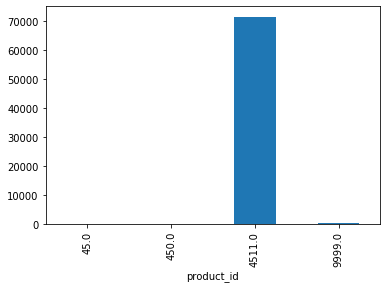

In [66]:
plot_count_per_id(transactions_postre_fresas_mascarpone)

In [67]:
for i in transactions_postre_fresas_mascarpone['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 4511.0 
-
postres fresas y mascarpone                               71402
postres tartaleta fresas y mascarpone                       684
postres fresas y mascarpone encargo line                     38
postres fresas y mascarpone encargo de                       38
postres fresas y mascarpone envio en el duro n del pan       19
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5073
Name: desc_normalized, dtype: int64

***Plotting id: 450.0 
-
postres mousse tres chocolates      82403
postres selva negra                  3116
postres milhojas frambuesa           2926
mini postres mus tres chocolates     2014
postres milhojas                     1976
Name: desc_normalized, dtype: int64

***Plotting id: 45.0 
-
postres mousse tres chocolates    34865
postres san marcos                  60

Seems that the filter is working :)

In [68]:
postre_fresas_mascarpone = filter_postre_fresas_mascarpone(unique_normalized_decriptions)

postre_fresas_mascarpone['target_names_prod_by_prod'] = 'postre de fresas y mascarpone'
list_of_dfs.append(postre_fresas_mascarpone)
postre_fresas_mascarpone.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,product_id,desc_normalized,target_names_prod_by_prod
3862959,4511.0,postres fresas y mascarpone,postre de fresas y mascarpone
5911144,9999.0,postres fresas y mascarpone,postre de fresas y mascarpone
5919722,9999.0,postres fresa y mascarpone,postre de fresas y mascarpone
5929928,9999.0,postres de fresas mascarpone,postre de fresas y mascarpone
5939938,9999.0,postres de fresas y mascarpone,postre de fresas y mascarpone


#### 2.3.9 Matching: tortel

In [69]:
def filter_tortel (df):
    tortel = df[df['desc_normalized'].str.contains('tortel')].copy()
    tortel = tortel[~tortel['desc_normalized'].str.contains('tortellini|mini')].copy()

    return tortel

In [70]:
transactions_tortel = filter_tortel(df_with_normalized_descriptions_transactions)

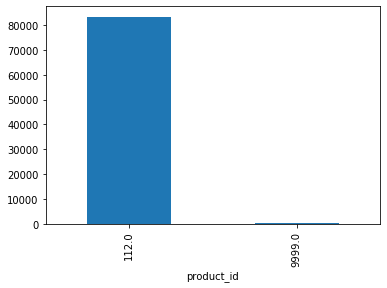

In [71]:
plot_count_per_id(transactions_tortel)

In [72]:
for i in transactions_tortel['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 112.0 
-
torteles                              82821
baguet multicereales                    437
ensaimadas piezas hacer a las 12 y      342
focaccias                               228
suizos piezas hacer las 12 y            209
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5073
Name: desc_normalized, dtype: int64



In [73]:
tortel = filter_tortel(unique_normalized_decriptions)

tortel['target_names_prod_by_prod'] = 'tortel'
list_of_dfs.append(tortel)
tortel.head(5)

,product_id,desc_normalized,target_names_prod_by_prod
194,112.0,torteles,tortel
11211,9999.0,tortelini solo eva,tortel
23951,9999.0,tortelini bolognesa,tortel
52522,9999.0,tortelini bolsa eva,tortel
4218346,9999.0,encargo380 torteles cocido para las tres,tortel


#### 2.3.10 Matching: baguette

In [74]:
def filter_baguette (df):
    baguette = df[df['desc_normalized'].str.contains('baguette|baguete|baguet')].copy()
    return baguette

In [75]:
transaction_baguette = filter_baguette(df_with_normalized_descriptions_transactions)

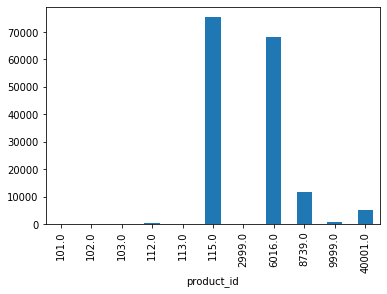

In [76]:
plot_count_per_id(transaction_baguette)

In [77]:
for i in transaction_baguette['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 6016.0 
-
baguet piezas 5 hora          60306
baguet 5 la ana                7942
baguet multicereales             19
tartas pan torrijas andes        19
barritas integrales piezas       19
Name: desc_normalized, dtype: int64

***Plotting id: 115.0 
-
baguette mallorca                 47215
baguett mallorca                  28177
suizos piezas hacer a las 12 y       38
merengue blanco                      19
pan integral                         19
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8227
julian de pimiento             8151
brandada de bacalao            6080
encargo julian de pimiento     5073
Name: desc_normalized, dtype: int64

***Plotting id: 102.0 
-
croissant francesa               86279
croissant andes marcos piezas      703
focaccias                          266
chapatitas ocio                    247
mini hamburguesitas                190
Name: desc_normalized, dtype: in

Per client indications we take id = 115.0 containing baguette

In [78]:
baguette = unique_normalized_decriptions[unique_normalized_decriptions['product_id']==115.0].copy()
baguette = baguette[baguette['desc_normalized'].str.contains('baguette|baguete|baguet')].copy()

baguette['target_names_prod_by_prod'] = 'baguette'
list_of_dfs.append(baguette)
baguette.head(5)

,product_id,desc_normalized,target_names_prod_by_prod
192,115.0,baguett mallorca,baguette
12114017,115.0,baguette mallorca,baguette
13137000,115.0,baguette mallorca cocido,baguette
23531473,115.0,baguette mallorca sin la bolsa mallorca,baguette
23539287,115.0,baguette mallorcasin bolsa mallorca,baguette


### 2.4 Concatenate results, merge them back to the  full list of normalized descriptions and evaluate its effectiveness<a id='a24'></a>

In [79]:
# Lets concatenate the results:
list_of_products_df = pd.concat(list_of_dfs, sort=False)

In [80]:
df_desc_normalized_vs_prod_by_prod = pd.merge(df_with_normalized_descriptions_transactions, list_of_products_df,how='left',on=['desc_normalized','product_id'])

In [81]:
# Merging test:

In [82]:
#Control merge size:
if (df_with_normalized_descriptions_transactions.shape[0] == df_desc_normalized_vs_prod_by_prod.shape[0] ): 
    test1 = "OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' "
else:
    test1 = "ERROR - 'df' has NOT the same size as 'df_desc_normalized_vs_prod_by_prod' "

print(test1)

OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' 


*NOTE:*

During the first executions of code with the full transactions file, this error was failing; 'df' had less rows than 'df_with_normalized_descriptions_transactions'. The reason for this was not easy to identify, however digging we found that that in the normalized description two products descriptions ware naming two different products in the description, however this was not the case for the raw description (before the spell-cheacker):

for example:
- Normalized prod description: 'tarta mousse 3 chocolates de 20 raciones con escrito sobre la tarta manzana y mini felicidades'
- Raw description: 'TARTA MOUSSE 3 CHOCOLATES DE 20 RACIONES CON ESCRITO SOBRE LA TARTA:  MARIANA Y DANI FELICIDADES'

Basically, the spell-corrector was solving some problems; normalizing 'trata' , 'taaarta' under 'tarta', but adding a new one: normalizing words that it doesnt know, that may be a correct word, to a word that it knows: 'MARIANA' to 'manzana'... Ofcourse this is a weakness, however from the manual inspections that were performed, it doesnt seem to happen often.

How we solve it by adding to the bakery products dataset: 
- A list of the most common male and female spanish names: in order to avoid confusion in the names

sources of the datasets:
- spanish names:https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177009&menu=resultados&secc=1254736195454&idp=1254734710990


Also, in this case we added some names that we found to the excel; the right thing to do should we had more time, would be to polish the dataset, by adding not just mallorca catalogue and names, but also a book in spanish. Perhaps, it would also be interesting to applying NLP to identify NAMES from the product descriptions and add them to the products dataset...

### 2.5 Test that data has not been corrputed<a id='a25'></a>

To test the integrity of the data, the original dataset should be the same as the last dataset without that we added, in other words, without the columns with the normalized descriptuons, and the target names:

In [83]:
# First, lets check the size of both dataframes:
print("Original dataset shape: {}".format(df.shape))
print("Resulting dataset shape: {}".format(df_desc_normalized_vs_prod_by_prod.shape))

Original dataset shape: (30550252, 6)
Resulting dataset shape: (30550252, 8)


The shape looks good, we were expecting the resulting dataset to have to columns more. Lets now evauate if they are actually the same dataset if we remove the added columns:

In [84]:
# Selecting original columnsd from the resulting df
df_result = df_desc_normalized_vs_prod_by_prod.loc[:, df.columns]

In [85]:
# Now, lets compare it with the original dataset, sorting them out in the same way:
df_result_sorted = df_result.sort_values(by = ['order_date','store','description','product_id', 'units_ordered']).reset_index().drop('index', axis = 1)
df_original_sorted = df.sort_values(by = ['order_date','store','description',  'product_id', 'units_ordered']).reset_index().drop('index', axis = 1)

In [86]:
df_result_sorted.head()

,product_id,description,order_date,section,store,units_ordered
0,615.0,ALASKAS FRAMBUESA,2008-01-01,0,AaUP,"2,00"
1,172.0,1/2 PAN DE MOLDE ENVUELTO,2008-01-01,0,AaUP,"0,00"
2,9999.0,3 RACIONES DE ENSALADA DE CAPON,2008-01-01,0,AaUP,"0,00"
3,9999.0,3 RACIONES VERDURAS SALTEADAS,2008-01-01,0,AaUP,"0,00"
4,3252.0,ACETATO 11 POOL NUEVO,2008-01-01,0,AaUP,"0,00"


In [87]:
df_original_sorted.head()

,product_id,description,order_date,section,store,units_ordered
0,615.0,ALASKAS FRAMBUESA,2008-01-01,0,AaUP,"2,00"
1,172.0,1/2 PAN DE MOLDE ENVUELTO,2008-01-01,0,AaUP,"0,00"
2,9999.0,3 RACIONES DE ENSALADA DE CAPON,2008-01-01,0,AaUP,"0,00"
3,9999.0,3 RACIONES VERDURAS SALTEADAS,2008-01-01,0,AaUP,"0,00"
4,3252.0,ACETATO 11 POOL NUEVO,2008-01-01,0,AaUP,"0,00"


In [88]:
# Now that they have the same columns, and are sorted using the same criteria, lets evaluate if they are the same:
comparison_result = df_result_sorted.equals(df_original_sorted)

if comparison_result == True:
    test2 = 'OK - Original dataset is the similar to resulting dataset'
else:
     test2 ='ERROR - Original dataset NOT found'

print(test2)

OK - Original dataset is the similar to resulting dataset


### 2.6 Filter dataset to only include the products from the list provided by the client, and save to csv<a id='a26'></a>

In [89]:
df_target_products = df_desc_normalized_vs_prod_by_prod[~df_desc_normalized_vs_prod_by_prod['target_names_prod_by_prod'].isnull()]
df_other_products = df_desc_normalized_vs_prod_by_prod[df_desc_normalized_vs_prod_by_prod['target_names_prod_by_prod'].isnull()]

In [90]:
df_target_products_file_name = exit_path + '1_filtered_transactions_not_clean.csv' 
df_target_products.to_csv(df_target_products_file_name, index = False, sep = ';' )
df_target_products.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
73,103.0,MINI NAPOLITANAS CREMA,2008-01-01,0,AeUP,"0,00",mini napolitanas crema,croissant petit
74,103.0,MINI NAPOLITANAS CHOCOLATE,2008-01-01,0,AeUP,"0,00",mini napolitanas chocolate,croissant petit
75,103.0,FOCACCIAS FUTBOL,2008-01-01,0,AeUP,"0,00",focaccias futbol,croissant petit
97,414.0,TARTA MILHOJAS FRAMBUESA 2º,2008-01-01,0,AeUP,"0,00",tarta milhojas frambuesa 2,milhojas frambuesa
98,414.0,TARTA MUS TRES CHOCOLATES 2º,2008-01-01,0,AeUP,"0,00",tarta mus tres chocolates 2,mousse tres chocolates


### 2.7 Error checking<a id='a27'></a>

In [91]:
print(test0)
print(test1)
print(test2)

OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' 
OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' 
OK - Original dataset is the similar to resulting dataset
